In [240]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [241]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
file_names.extend(['tnr_12702_dtm.tif'])
file_names.extend(['Tnr_12702_2021_Ortho.tif'])

# file_names.extend(['Tnr_11044_D-20210707_DSM.tif'])
# file_names.extend(['tnr_11044_dtm.tif'])
# file_names.extend(['Tnr_11044_2021_Ortho.tif'])

# file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11626_dtm.tif'])
# file_names.extend(['Tnr_11626_2021_Ortho.tif'])

# file_names.extend(['Tnr_11090_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11090_dtm.tif'])
# file_names.extend(['Tnr_11090_2021_Ortho.tif'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

# io.print_raster_info(paths)

### Reproject all rasters to same area & resolution

In [242]:
importlib.reload(io)

# Set final resolution of all rasters
resolution = 0.2

# Reproject all rasters
bands, mask, A, bound = io.reproject_all_intersect(paths, resolution=resolution)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define primary and (normalized) secondary channels

In [243]:
importlib.reload(io)

# Primary raster channels 
cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

# Secondary raster channels
downscale = 0
cs, shape_in, shape_out = io.define_channels(cs_prim, downscale=downscale)

px_width = resolution * 2**downscale
print(f"Primary channel names: {[k for k in cs_prim]}")
print(f"Secondary channel names: {[k for k in cs]}")
print(f"Pixel width: {px_width:.1f} [m]")
print(f"Image shape: {shape_out} [px]")

Primary channel names: ['dsm', 'dtm', 'blue', 'red', 'green', 're', 'nir']
Secondary channel names: ['blue', 'red', 'green', 're', 'nir', 'chm', 'ndvi', 'rgb', 'h', 'l', 's']
Pixel width: 0.2 [m]
Image shape: (1994, 1831) [px]


### Segmentation -> Objects
#### (1) Segmentation
1. Local gaussian thresholding -> mask
2. Marker based watershed with markers generated by local peaks in distance transformation of mask

In [244]:
importlib.reload(segment)

thresh_dict={
    'downscale': 1,
    'width':30,
    'blur':False,
}
water_dict={
    'downscale': 0,
    'peak_dist': 1.2,
}

labels, bounds, mask_seed, mask_global, thresh_dict, water_dict = segment.main(
    cs_prim,
    resolution,
    thresh_dict,
    water_dict,
)

Thresholding params.:
{'downscale': 1, 'width': 30, 'blur': False, 'channel': 'l', 'shape': (997, 916), 'px_width': 0.4}
Watershed params.:
{'downscale': 0, 'peak_dist': 1.2, 'channel': 'l', 'shape': (1994, 1831), 'px_width': 0.2}

    ... (thresholding) Gaussian thresholding kernel width: 30.0 [m] = 75 [px]
    ... (watershed) Removing holes of area: 0.00 [m**2] = 0 [px]
    ... (watershed) Peaks in distance transform separated by minimum distance: 1.2 [m] = 5 [px]


#### (2) Plot segmentation results

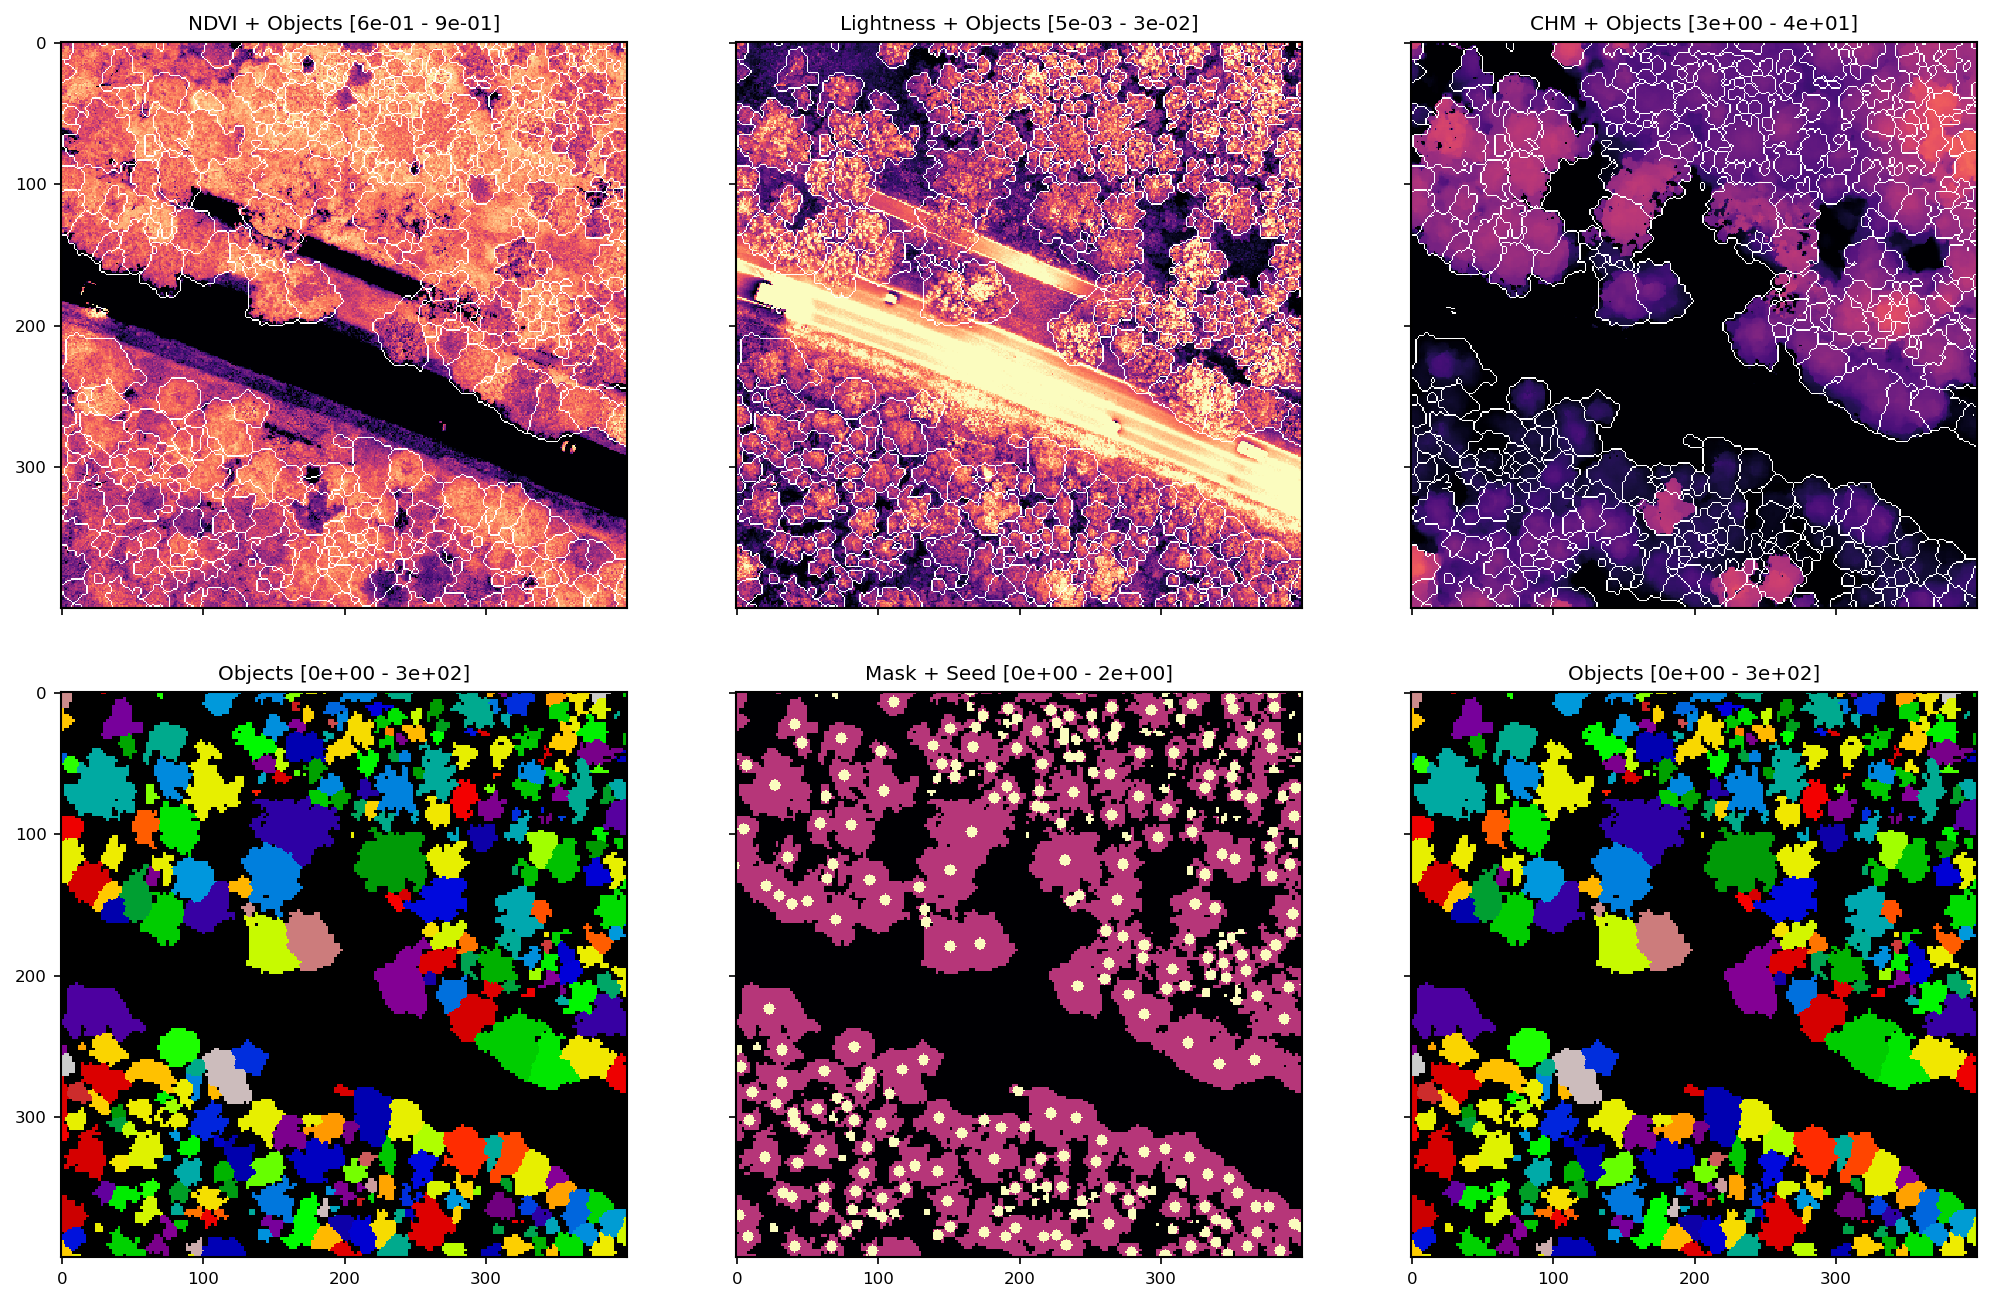

In [258]:
segment_l = cs['l'].copy()
segment_l[bounds == 1] = np.nan

segment_ndvi = cs['ndvi'].copy()
segment_ndvi[bounds == 1] = np.nan

segment_chm = cs['chm'].copy()
segment_chm[bounds == 1] = np.nan

channels = [
    segment_ndvi, segment_l, segment_chm, 
    labels, mask_seed, labels,
]
use_random_cmap = [
    False, False, False, 
    True, False, True, 
    ]
channels_names = [
    'NDVI + Objects','Lightness + Objects', 'CHM + Objects', 
    'Objects', 'Mask + Seed', 'Objects',
]
contrasts = [
    (0.6, 0.9), (5e-3, 3.3e-2), (3, 40), 
    None, None, None,
]

# ROI
width = 200
x_center = 1000
y_center = 1000
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    # mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    n_cols_rows=(3,2),
)

# plt.savefig(r'C:\Users\flori\Desktop\plots\220406\220406_tnr12702_CHM.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220406\220406_tnr11044_CHM.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220406\220406_tnr11626_CHM.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220406\220406_tnr11090_CHM.pdf', transparent=True)

### Object properties
#### (1) Extract object properties

In [246]:
importlib.reload(obj_props)
props, names = obj_props.extract_props(labels, cs, px_width)

['label', 'area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'equivalent_diameter_area', 'perimeter', 'perimeter_crofton', 'feret_diameter_max', 'eccentricity', 'extent', 'solidity', 'min_blue', 'mean_blue', 'max_blue', 'min_red', 'mean_red', 'max_red', 'min_green', 'mean_green', 'max_green', 'min_re', 'mean_re', 'max_re', 'min_nir', 'mean_nir', 'max_nir', 'min_chm', 'mean_chm', 'max_chm', 'min_ndvi', 'mean_ndvi', 'max_ndvi', 'min_rgb', 'mean_rgb', 'max_rgb', 'min_h', 'mean_h', 'max_h', 'min_l', 'mean_l', 'max_l', 'min_s', 'mean_s', 'max_s']


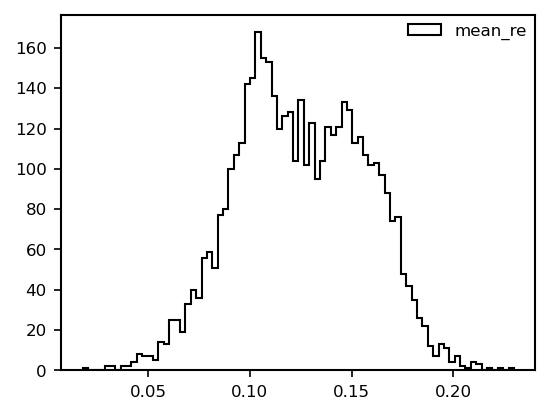

In [278]:
print(names)
f, ax = plt.subplots(figsize=[4,3])

feature = 'mean_re'
idx = names.index(feature)
_ = ax.hist(
    props[:, idx],
    bins=80,
    histtype='step',
    label=feature,
    )

_ = ax.legend()

['label', 'area', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'equivalent_diameter_area', 'perimeter', 'perimeter_crofton', 'feret_diameter_max', 'eccentricity', 'extent', 'solidity', 'min_blue', 'mean_blue', 'max_blue', 'min_red', 'mean_red', 'max_red', 'min_green', 'mean_green', 'max_green', 'min_re', 'mean_re', 'max_re', 'min_nir', 'mean_nir', 'max_nir', 'min_chm', 'mean_chm', 'max_chm', 'min_ndvi', 'mean_ndvi', 'max_ndvi', 'min_rgb', 'mean_rgb', 'max_rgb', 'min_h', 'mean_h', 'max_h', 'min_l', 'mean_l', 'max_l', 'min_s', 'mean_s', 'max_s']


Text(0, 0.5, 'mean_re')

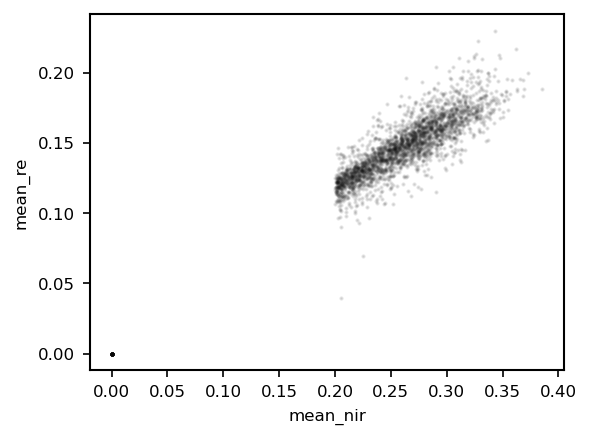

In [277]:
print(names)
f, ax = plt.subplots(figsize=[4,3])

feature1 = 'mean_nir'
idx1 = names.index(feature1)

feature2 = 'mean_re'
idx2 = names.index(feature2)

feature3 = 'eccentricity'
idx3 = names.index(feature3)

x = props[:, idx1].flatten()
y = props[:, idx2].flatten()

_ = ax.scatter(
    x,
    y,
    # c=props[:, idx3],
    s=1,
    alpha=0.1,
    )

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)

In [249]:
# i = np.random.randint(0,len(props))
# # i = 2593
# print(i)
# prop = props[i]

# mask = prop['image_filled']
# slice = prop['slice']

# l = prop['image_intensity']
# ndvi = cs['ndvi'][slice] * mask

# channels = [mask, l, ndvi]
# contrasts = [(0,1), (1e-3, 3.5e-2), (0.5,1)]
# channel_names = ['Mask', 'L' , 'NDVI']


# f, axs = visual.show_channels(
#     channels,
#     contrasts=contrasts,
#     channel_names=channel_names,
#     zoom=0.8,
# )

# y,x = prop['centroid_local']
# yw,xw = prop['centroid_weighted_local']
# _ = axs[1].scatter(x, y, s=20, marker='o', fc='w', ec='k')
# _ = axs[1].scatter(xw, yw, s=40, marker='s', fc='none', ec='k')
